Found 11072 files belonging to 10 classes.
Found 1810 files belonging to 10 classes.


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,266 (3.87 MB)

 Trainable params: 1,002,154 (3.82 MB)

 Non-trainable params: 12,112 (47.31 KB)

Class Weights:  {0: 1.0}
Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 629s 3s/step - accuracy: 0.4384 - loss: 1.7382 - val_accuracy: 0.6917 - val_loss: 0.9184 - learning_rate: 1.0000e-04
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 572s 3s/step - accuracy: 0.8402 - loss: 0.5279 - val_accuracy: 0.7028 - val_loss: 0.9543 - learning_rate: 1.0000e-04
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 597s 3s/step - accuracy: 0.8905 - loss: 0.3648 - val_accuracy: 0.7414 - val_loss: 0.8082 - learning_rate: 1.0000e-04
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 588s 3s/step - accuracy: 0.9181 - loss: 0.2907 - val_accuracy: 0.7884 - val_loss: 0.6871 - learning_rate: 1.0000e-04
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 594s 3s/step - accuracy: 0.9339 - loss: 0.2243 - val_accuracy: 0.8287 - val_loss: 0.5653 - learning_rate: 1.0000e-04
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 591s 3s/step - accuracy: 0.9344 - loss: 0.2120 - val_accuracy: 0.8558 - val_loss: 0.4765 - learning_rate: 1.0000e-04
Epoch 7/20
173/173 ━━━━━━━━━━━━━━

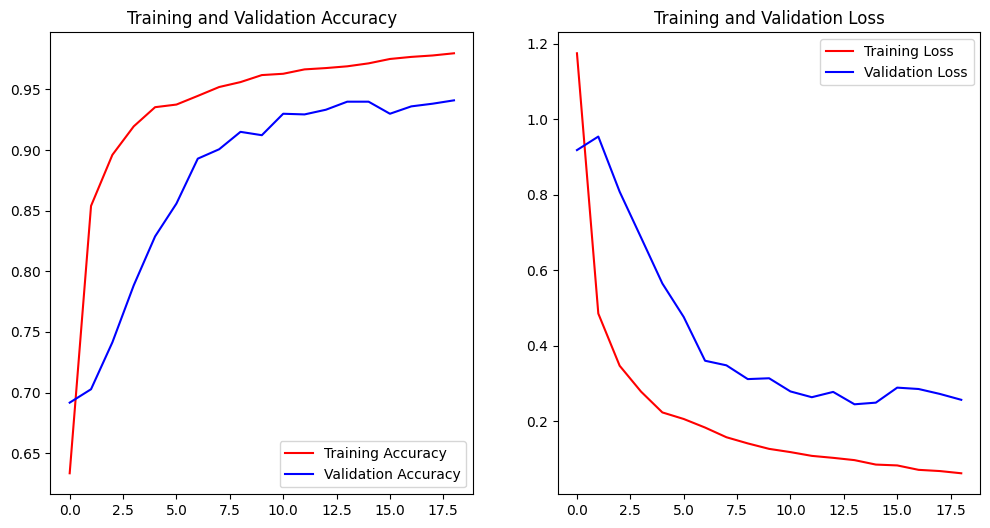

Found 654 files belonging to 10 classes.
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 647ms/step - accuracy: 0.9578 - loss: 0.1717
Test Accuracy: 95.26%


In [25]:
# Import Libraries
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from sklearn.utils.class_weight import compute_class_weight

TRAIN_DIR = 'C:/bangkit/code/dataset/train'
VALIDATION_DIR = 'C:/bangkit/code/dataset/validation'
TEST_DIR = 'C:/bangkit/code/dataset/test'

def train_val_datasets():
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=TRAIN_DIR,
        batch_size=64,
        image_size=(224, 224),
        label_mode='categorical'
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=VALIDATION_DIR,
        batch_size=64,
        image_size=(224, 224),
        label_mode='categorical'
    )

    # Augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.1)
    ])

    # Normalize
    train_dataset = train_dataset.map(lambda x, y: (data_augmentation(preprocess_input(x)), y))
    validation_dataset = validation_dataset.map(lambda x, y: (preprocess_input(x), y))

    return train_dataset, validation_dataset

train_dataset, validation_dataset = train_val_datasets()

# Define Model MobileNetV3
def create_model():
    # Load pre-trained MobileNetV3 without the top classification layer
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True  # Unfreeze base model layers untuk fine-tuning

    # Add custom classification head
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')  # Output untuk 11 classes
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR untuk fine-tuning
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()

def compute_class_weights(dataset):
    class_indices = []
    for images, labels in dataset.unbatch():
        for label in labels:
            class_indices.append(np.argmax(label))
    class_indices = np.array(class_indices)
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    return {i: w for i, w in enumerate(class_weights)}

class_weights_dict = compute_class_weights(train_dataset)

print("Class Weights: ", class_weights_dict)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Training
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_history(history)

# Evaluate
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    batch_size=64,
    image_size=(224, 224),
    label_mode='categorical'
)

test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [26]:
model.save("model_makanan.h5")

In [15]:
model.save('saved_model/food_recog')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=saved_model/food_recog.

In [27]:
model.save('model_makanan_keras.keras')